In [3]:
# import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
tf.random.set_seed(42)
np.random.seed(42)


import os
import sys

In [27]:
#idx = int(os.environ["SLURM_ARRAY_TASK_ID"])

#feature_setting = str(os.environ["Setting"])

#model_setting = str(os.environ["Model"])


"""
Define Parameter Configuration to Model

    Parameters
    ----------
    alpha : float, linear stiffness
    beta  : float, non linearity in the restoring force
    gamma : float, amplitude of the periodic driving force
    delta : float, amount of damping
    omega : float, angular frequency of the periodic driving force
"""   

parameter_list = [{'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}]



dict_param = parameter_list[0]

from Array_Submission_8.OtherFunctions import *
from  Array_Submission_8.BaseDuffing import Duffing

num_samples_ml = 1000


In [28]:
duffing = Duffing(parameters = dict_param)
eom = duffing.eom
#suffix = feature_setting + "_" + model_setting + "_" + duffing.suffix

end_time = 100
duffing.generate(num_samples_ml, samples = 100, end_time = end_time) #samples prev 100
duffing.scale_features()
X_train, X_test, y_train, y_test = train_test_split(duffing.X_df[duffing.features], 
                                                    duffing.X_df[duffing.labels], test_size=0.1, random_state=42)

X = X_test
y = y_test

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)]

Generating Data…: 100%|████████████████| 1000/1000 [00:29<00:00, 33.56it/s]


In [29]:
histories = {}

In [32]:
for batch_size in [32, 64, 128, 256, 512, 1024, 2048]:
    print(batch_size)
    model = MLModel()

    history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, validation_split=0.2, 
                      batch_size=batch_size, shuffle=True, callbacks=callbacks, verbose=0)
    histories[str(batch_size)] = history
    #with open('Models/TrainingHistory/Model_batch_histories', 'wb') as file_pi:
    #    pickle.dump(histories, file_pi)

32
64
128
256
512
1024
2048


In [12]:
histories

{'32': <keras.callbacks.History at 0x28f4854f910>,
 '64': <keras.callbacks.History at 0x28f3ad16400>,
 '128': <keras.callbacks.History at 0x28f0c02e0d0>,
 '256': <keras.callbacks.History at 0x28f0c1efc10>,
 '512': <keras.callbacks.History at 0x28f0d3c91c0>,
 '1024': <keras.callbacks.History at 0x28f0f56e0a0>,
 '2048': <keras.callbacks.History at 0x28f0f771640>}

In [ ]:

for i, key in enumerate(histories):
    histories[key].history['loss']

In [51]:
histories["2048"].history['loss']

[0.5555112957954407,
 0.5070269107818604,
 0.5059888958930969,
 0.5005958676338196,
 0.49613600969314575,
 0.49274951219558716,
 0.4899922013282776,
 0.48696500062942505,
 0.4817669689655304,
 0.475796103477478,
 0.47099244594573975,
 0.46069949865341187,
 0.4548649489879608,
 0.45039820671081543,
 0.4456929862499237,
 0.440491646528244,
 0.44054529070854187,
 0.43731245398521423,
 0.43313056230545044,
 0.4311903119087219,
 0.42921313643455505,
 0.42881110310554504,
 0.428790420293808,
 0.4232659935951233,
 0.42183560132980347,
 0.4205728769302368,
 0.41601961851119995,
 0.4136645495891571,
 0.4142146408557892,
 0.4120641350746155,
 0.4159870147705078,
 0.41388267278671265]

In [64]:
int("18")

18

No handles with labels found to put in legend.


0
1
2
3
4
5
6


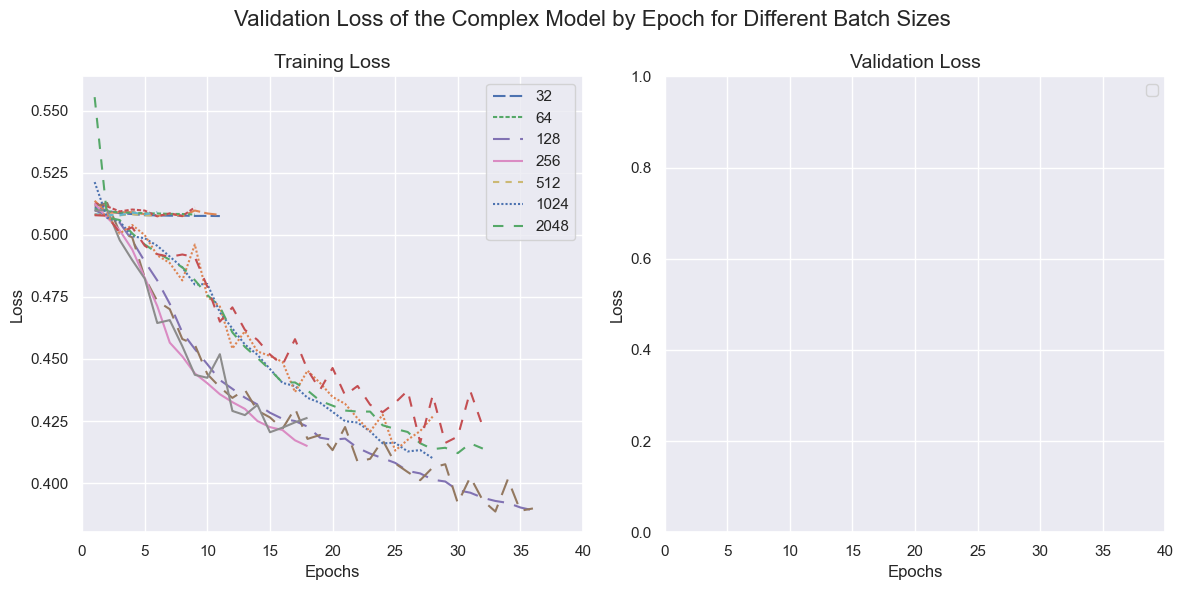

In [74]:
f, axs = plt.subplots(1, 2, figsize = (12,6), gridspec_kw = dict(width_ratios=[4,4]))
# evaluate the fitting validation and training losses
lines_ = [(6,2), (2,1), (8,5), (1,0), (3,3), (1,1), (5,5)]

for i, key in enumerate(histories):
    print(i)
    loss = histories[key].history['loss']
    val_loss = histories[key].history['val_loss']
    epochs = range(1, len(loss) + 1)
    axs[0].plot(epochs, histories[key].history['loss'], label=key, dashes = lines_[i])
    axs[0].plot(epochs, histories[key].history['val_loss'], dashes = lines_[i])
    #plt.plot(data = histories[key].history, x = epochs, y='val_loss',ax=axs[1], label=key, style = True,
    #             dashes = lines_[i])
    
axs[0].set(xlim=(0, 40))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title(r"Training Loss", fontsize = 14)
axs[0].legend()

axs[1].set(xlim=(0, 40))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title(r"Validation Loss", fontsize = 14)
axs[1].legend()
f.suptitle(r"Validation Loss of the Complex Model by Epoch for Different Batch Sizes", fontsize = 16)

                      
f.tight_layout()
f
f.savefig("Images/BatchSize.svg", dpi='figure')

In [78]:
f, axs = plt.subplots(1, 1, figsize = (8,6), gridspec_kw = dict(width_ratios=[4]))
# evaluate the fitting validation and training losses
lines_ = [(6,2), (2,1), (8,5), (1,0), (3,3), (1,1), (5,5)]

for i, key in enumerate(histories):
    print(i)
    loss = histories[key].history['loss']
    val_loss = histories[key].history['val_loss']
    epochs = range(1, len(loss) + 1)
    axs.plot(epochs, histories[key].history['loss'], label="Training: "+key, dashes = lines_[i])
    axs.plot(epochs, histories[key].history['val_loss'], label="Validation: "+key, dashes = lines_[i])
    #plt.plot(data = histories[key].history, x = epochs, y='val_loss',ax=axs[1], label=key, style = True,
    #             dashes = lines_[i])
    
axs.set(xlim=(0, 40))
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.set_title(r"Loss of the Complex Model by Epoch for Different Batch Sizes", fontsize = 14)
axs.legend()

#f.suptitle(r"Validation Loss of the Complex Model by Epoch for Different Batch Sizes", fontsize = 16)

                      
f.tight_layout()
f
f.savefig("Images/BatchSize.svg", dpi='figure')

0
1
2
3
4
5
6


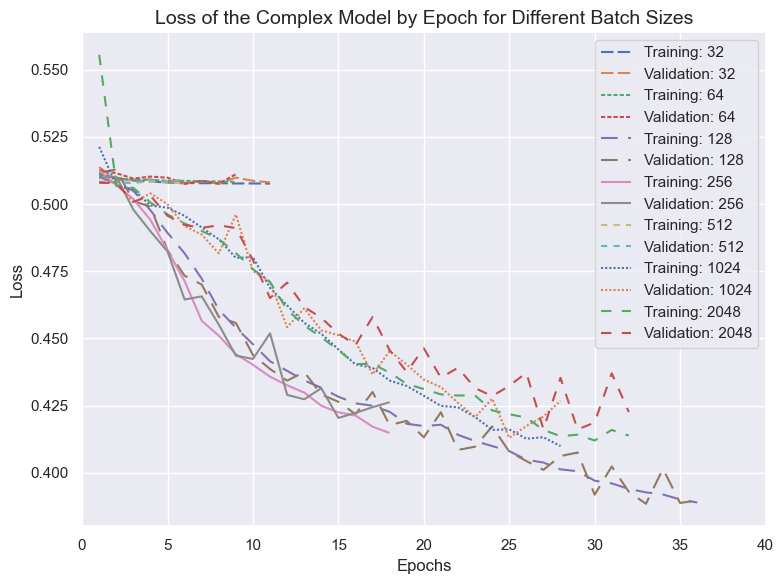

In [79]:
f

In [ ]:
with open('Images/BatchSize', 'wb') as file_pi:
    pickle.dump(f, file_pi)

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


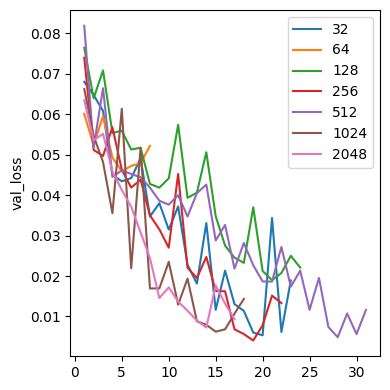

In [25]:
f